<a href="https://colab.research.google.com/github/guswns3396/ICME-2023/blob/main/CIFAR10_Walkthrough_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

import torch.nn as nn #tfkl,

from torch.utils.data import TensorDataset, DataLoader

import torch.nn.functional as F

from torch.optim import SGD, Adam
import matplotlib.pyplot as plt

import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

In [ ]:
transform =transforms.Compose([transforms.ToTensor()])

In [ ]:
train_dataset = CIFAR10(root='data/', train=True, download=True, transform=transform)
validation_dataset = CIFAR10(root='data/', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:13<00:00, 12674655.02it/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


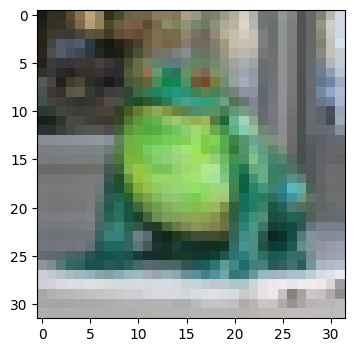

In [ ]:
sample_image = train_dataset[19][0]
plt.figure(figsize=(4,4))
plt.imshow(sample_image.permute(1, 2, 0));

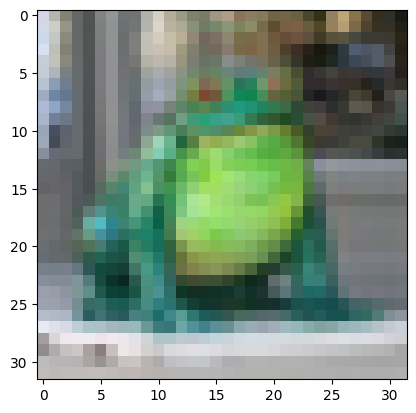

In [ ]:
image1 = transforms.RandomHorizontalFlip()(sample_image)
plt.imshow(image1.permute(1, 2, 0));

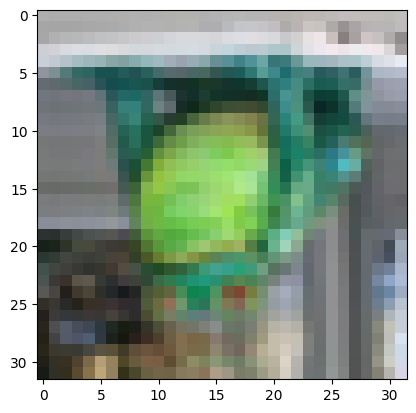

In [ ]:
image2 = transforms.RandomVerticalFlip()(sample_image)
plt.imshow(image2.permute(1, 2, 0));

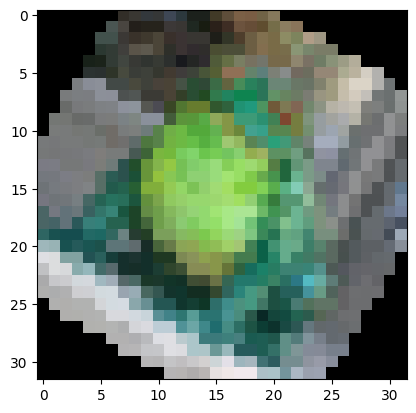

In [ ]:
image3 = transforms.RandomRotation(45)(sample_image)
plt.imshow(image3.permute(1, 2, 0));

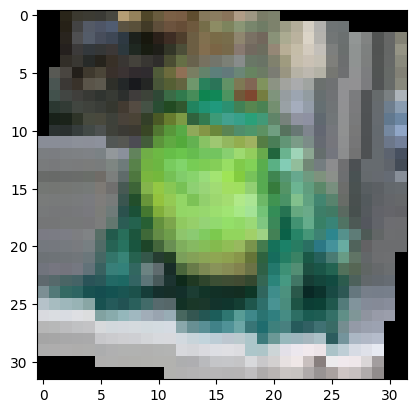

In [ ]:
image4 = transforms.RandomAffine(10)(sample_image)
plt.imshow(image4.permute(1, 2, 0));

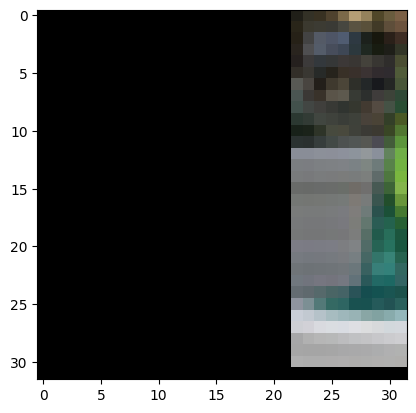

In [ ]:
image5 = transforms.RandomCrop(32,32)(sample_image)
plt.imshow(image5.permute(1, 2, 0));

In [ ]:
train_transform =transforms.Compose([transforms.RandomHorizontalFlip(),
                                     #transforms.RandomVerticalFlip(),
                                     transforms.RandomCrop(32),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                     ])

In [ ]:
validation_transform =transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
train_dataset = CIFAR10(root='data/', train=True, download=True, transform=train_transform)
validation_dataset = CIFAR10(root='data/', train=False, download=True, transform=validation_transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_dl = DataLoader(train_dataset, batch_size= 128, shuffle=True, num_workers=2)
validation_dl = DataLoader(validation_dataset, batch_size= 128, num_workers=2)

In [ ]:
for xb,yb in train_dl:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([128, 3, 32, 32])
torch.Size([128])


In [ ]:
def denorm(images, means=0.5, stds=0.5):
  images_standard = (images*means)+stds
  return images_standard

In [ ]:
print(train_dataset.classes)
print(len(train_dataset.classes), " classes")
print(len(train_dataset))
print(len(validation_dataset))

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
10  classes
50000
10000


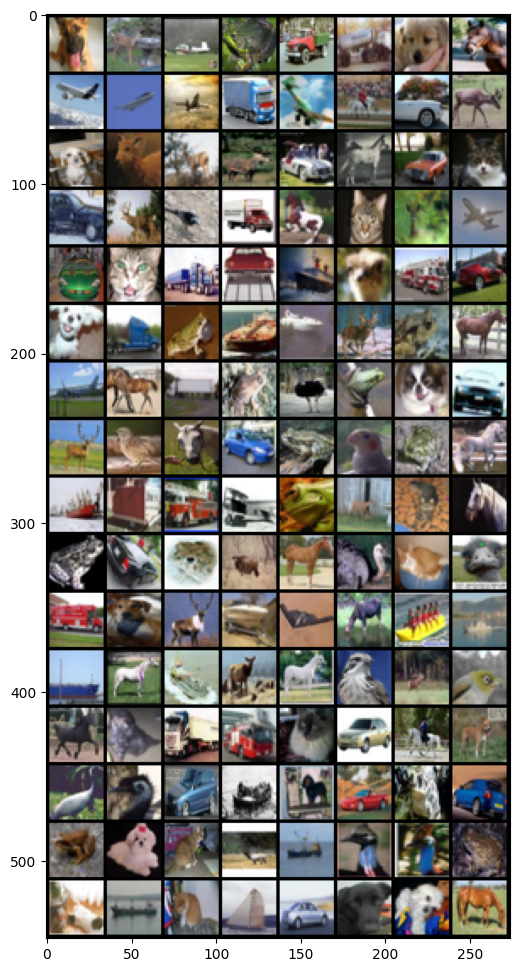

In [ ]:
grid_img = torchvision.utils.make_grid(denorm(xb), nrow=8)
plt.figure(figsize=(12,12))
plt.imshow(grid_img.permute(1, 2, 0));

In [ ]:
class MyCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)

    self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)

    self.pool = nn.MaxPool2d(2,2)
    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(4096, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 10)


  def forward(self, xb):
    x = self.relu(self.conv2(self.relu(self.conv1(xb))))
    x = self.pool(x)

    x = self.relu(self.conv4(self.relu(self.conv3(x))))
    x = self.pool(x)

    x = self.relu(self.conv6(self.relu(self.conv5(x))))
    x = self.pool(x)

    x = self.flatten(x)

    x = self.relu(self.fc2(self.relu(self.fc1(x))))

    return self.fc3(x)

In [ ]:
def get_accuracy(scores, labels):
  softmax_scores = F.softmax(scores, dim=1)
  _, predictions = torch.max(softmax_scores, dim=1)
  acc = torch.sum(predictions == labels).item()/len(labels)
  return acc

In [ ]:
def get_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [ ]:
device = get_device()
print(device)

cuda


In [ ]:
lr = 0.001
num_epochs = 5
model = MyCNN().to(device)

loss_fn = F.cross_entropy
opt = Adam(model.parameters(),lr=lr)

In [ ]:
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
  model.train()
  train_batch_losses = []
  for xb, yb in train_dl:
    xb = xb.to(device)
    yb = yb.to(device)
    outputs = model(xb)
    loss = loss_fn(outputs, yb)
    opt.zero_grad()
    loss.backward()
    opt.step()
    train_batch_losses.append(loss.detach().item())

  training_losses.append(torch.tensor(train_batch_losses).mean().item())

  model.eval()
  batch_accuracies =[]
  validation_batch_losses = []
  for xb, yb in validation_dl:
    xb = xb.to(device)
    yb = yb.to(device)
    outputs = model(xb)
    batch_accuracy = get_accuracy(outputs, yb)
    batch_accuracies.append(batch_accuracy)
    loss = loss_fn(outputs, yb)
    validation_batch_losses.append(loss.detach().item())

  validation_losses.append(torch.tensor(validation_batch_losses).mean().item())

  epoch_accuracy = torch.tensor(batch_accuracies).mean().item()
  print(f"Epoch: {epoch+1} \t Accuracy: {epoch_accuracy}")

Epoch: 1 	 Accuracy: 0.5243275165557861
Epoch: 2 	 Accuracy: 0.6497231125831604
Epoch: 3 	 Accuracy: 0.7313093543052673
Epoch: 4 	 Accuracy: 0.7667128443717957
Epoch: 5 	 Accuracy: 0.7831289768218994


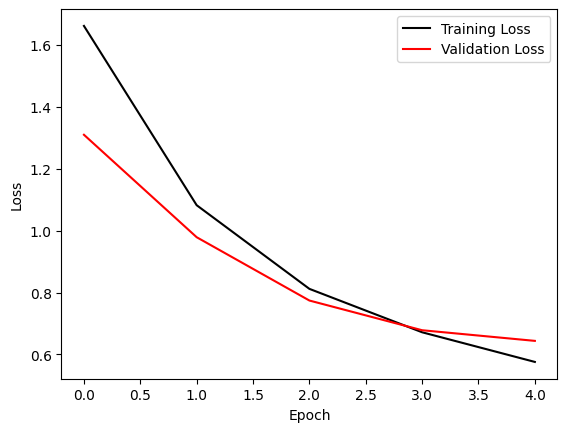

In [ ]:
plt.plot(training_losses,'k', label="Training Loss")
plt.plot(validation_losses,'r', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()